In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

#get the data set
df = pd.read_csv('black_friday_data_kaggle.csv', error_bad_lines=False)

1. transform the features for decision tree
2. hot encode gender, age, city, 
3. remove the p in the product ids



In [0]:
df_training = df
users = len((df_training['User_ID']).unique())
product_ids = len((df_training['Product_ID']).unique())
occupations = len((df_training['Occupation']).unique())
cat_2 = len((df_training['Product_Category_2']).unique())
print("number of occupations", occupations)
print("number of product ids", product_ids)
print("number of users", users)
print("number of Product_Category_2", cat_2)

number of occupations 21
number of product ids 3623
number of users 5891
number of Product_Category_2 18


In [0]:
hot = (['Gender',	'Age',	'Occupation',	'City_Category',	
                'Marital_Status',	'Product_Category_2'])

df = df.fillna(0)
df1 = df.loc[: ,['Product_ID', 'Purchase', 'Product_Category_1', 'User_ID']]
df2 = pd.get_dummies(df.loc[:, hot])
df2 = pd.concat([df1, df2], axis = 1)
df_product = (df2.groupby(by='Product_ID', as_index=False).agg({ 'Product_Category_1': lambda x: x.iloc[0], 'Gender_F' : pd.Series.mean,
                 'Gender_M' : pd.Series.mean,'Marital_Status' : pd.Series.mean, 'Product_Category_2' : lambda x: x.iloc[0],
                    'Purchase' : pd.Series.mean, 'Occupation' : pd.Series.mean,'User_ID': pd.Series.nunique, 'Age_0-17': pd.Series.sum,
                           'Age_18-25': pd.Series.sum, 'Age_26-35' : pd.Series.sum,'Age_36-45':pd.Series.sum,
                            'Age_46-50': pd.Series.sum, 'Age_51-55' : pd.Series.sum, 'Age_55+' : pd.Series.sum,
                                  'City_Category_A': pd.Series.sum, 'City_Category_B': pd.Series.sum, 
                                       'City_Category_C': pd.Series.sum} ))
df_product['Log_Num_Users'] = np.log(df_product.User_ID)
                                                         

We one-hot encoded gender, age, occupation, city, marital status, and product category 2, then we took the mean of most of the categories and took the sum of ages and cities. Then we took the log of the number of users to work with comparable numbers 

In [0]:
df_train = df_product[df_product.Product_Category_1 != -1]
df_test = df_product[df_product.Product_Category_1 == -1] # Not to be touched until the model is trained and ready

# Divide the training data into test and train data to measure accuracy
y = df_train['Product_Category_1']
X = df_train.drop('Product_Category_1', axis=1)


In [0]:
features = (['Log_Num_Users', 'User_ID', 'Gender_F', 'Gender_M', 'Marital_Status','Product_Category_2','Purchase','Occupation','User_ID','Age_0-17',
          'Age_18-25','Age_26-35','Age_36-45', 'Age_46-50','Age_51-55','Age_55+','City_Category_A','City_Category_B','City_Category_C'])
X_DT = X[features]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_DT, y, test_size=0.33, random_state=42)

Split the data into 2/3 training and 1/3 testing 

In [0]:
len(y)
print(len(X_train))
len(y_train)

1618


1618

###Kmean and Knn

In [0]:
kmean = KMeans()
knn = KNeighborsClassifier(18)

knn.fit(X_train, y_train)

#kmean_scores = cross_val_score(kmean, X_train, y_train, cv=5)
knn_scores = cross_val_score(knn, X_train, y_train, cv=5)

#print('Kmean average score', kmean_scores.mean())
print('Knn average score', knn_scores.mean())

Knn average score 0.5724336364741084


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [0]:
kmean.fit(X_train, y_train)
knn.fit(X_train, y_train)

y_pred1 = kmean.predict(X_test)
y_pred2 = knn.predict(X_test)

print('Kmean accuracy', float(accuracy_score(y_pred1, y_test))*100, '%')
print('Knn accuracy', float(accuracy_score(y_pred2, y_test))*100, '%')


Kmean accuracy 0.8771929824561403 %
Knn accuracy 58.39598997493734 %


### Tree with AdaBoost

In [0]:
dtree = tree.DecisionTreeClassifier(max_depth=13)
treeboost = AdaBoostClassifier(dtree)
scores = cross_val_score(treeboost, X_train, y_train, cv=5)
scores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


array([0.66566265, 0.67278287, 0.65217391, 0.70846395, 0.67924528])

Using the cross validation score, the max depth with the highest average cross validation score was at max_depth = 13

In [0]:

 
clf = treeboost.fit(X_train, y_train)

y_pred = clf.predict(X_train)
print('Training data accuracy', float(accuracy_score(y_pred, y_train))*100, '%')


y_pred = clf.predict(X_test)
print('Testing data accuracy', float(accuracy_score(y_pred, y_test))*100, '%')


Training data accuracy 100.0 %
Testing data accuracy 71.9298245614035 %


### Tree with AdaBoost and Bagging

In [0]:
from sklearn.ensemble import BaggingClassifier
dtree = tree.DecisionTreeClassifier(max_depth=9)

bagg = BaggingClassifier(base_estimator = AdaBoostClassifier(dtree))
scores = cross_val_score(bagg, X_train, y_train, cv=5)
scores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


array([0.6626506 , 0.67889908, 0.72981366, 0.7492163 , 0.71069182])

Using bagging and adaboost, the max depth that yielded the highest average cross validation score was at max_depth = 9

In [0]:
bagg.fit(X_train, y_train)
pre = bagg.predict(X_test)
ac = accuracy_score(y_test, pre)
ac

0.7180451127819549

The accuracy of the adaboost and bagging slightly improved the accuracy 

### Random Forest 

In [0]:
rf = RandomForestClassifier(random_state = 463)

parameters = {"min_samples_leaf": [2],
             "n_estimators": [int(x) for x in range(39, 45)], 
             "max_features": [int(x) for x in range(15, 19)], 
             }
clf = GridSearchCV(estimator = rf, param_grid = parameters, verbose = 2, n_jobs = -1, cv = 5, scoring = "accuracy")
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   44.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=463, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [2], 'n_estimators': [39, 40, 41, 42, 43, 44], 'max_features': [15, 16, 17, 18]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [0]:
clf.best_params_

{'max_features': 15, 'min_samples_leaf': 2, 'n_estimators': 39}

Trying a random forest model, the parameters being tuned included the min_samples_leaf, n_estimators, and max_features. Using the GridSearchCV with 5 folds, the parameters converged to max_features = 17, min_samples_leaf = 2, and n_estimators = 43

In [0]:
accuracy_score(clf.predict(X_train), y_train)

0.9728059332509271

In [0]:
accuracy_score(clf.predict(X_test), y_test)

0.7243107769423559

The accuracy from the random forest model is very similar to the accuracy from the bagging model so will try to predict final dataset using both models

### Predictions

In [0]:
fclf = treeboost.fit(X_DT, y)

y_pred = fclf.predict(X_train)
#print('Training data accuracy', float(accuracy_score(y_pred, y))*100, '%')

In [0]:

y_pred_test = fclf.predict(df_test[features])

In [0]:
# write to submission file

df_sub = pd.DataFrame({'Product_ID': df_test['Product_ID'],
                   'Product_Category_1': y_pred_test
                   })
df_sub.to_csv('submission_file.csv', index=False)

In [0]:
f_rf = RandomForestClassifier(max_features=17, min_samples_leaf=2, n_estimators=43, random_state = 463)
f_rf.fit(X_DT, y) 
f_rf_pred = f_rf.predict(df_test[features])
rf_sub = pd.DataFrame({"Product_ID": df_test["Product_ID"], 
                      "Product_Category_1": f_rf_pred})
rf_sub.to_csv("submission_rf.csv", index = False)

In [0]:
df_training = X_DT
df_training.head()


,Log_Num_Users,User_ID,Gender_F,Gender_M,Marital_Status,Product_Category_2,Purchase,Occupation,User_ID,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C
1207,4.382027,80,0.200000,0.800000,0.300000,0.0,7168.487500,8.200000,80,0,14,33,17,4,10,2,27,36,17
1208,3.555348,35,0.142857,0.857143,0.342857,8.0,13106.685714,7.514286,35,0,3,22,6,0,2,2,13,18,4
1209,5.513429,248,0.225806,0.774194,0.314516,5.0,8216.020161,7.923387,248,11,71,116,31,10,7,2,65,128,55
1210,2.484907,12,0.416667,0.583333,0.250000,0.0,6755.166667,9.750000,12,1,1,6,2,0,2,0,4,6,2
1211,6.173786,480,0.231250,0.768750,0.356250,16.0,5362.604167,7.560417,480,17,132,213,73,22,17,6,129,207,144


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'distribution of purchase')

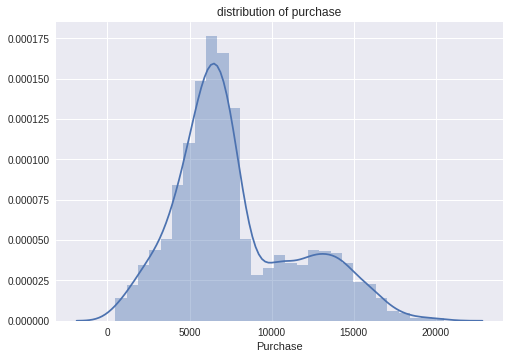

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.distplot(df_training['Purchase'])
plt.title('distribution of purchase')

The number of purchases seem demonstrate a bimodal distribution, with the first at around 7000 purchases and the second at around 13000 purchases 

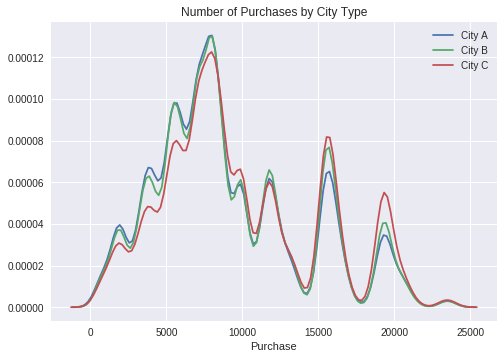

In [0]:
df_A = df[df["City_Category"] == "A"]
df_B = df[df["City_Category"] == "B"]
df_C = df[df["City_Category"] == "C"]

sns.distplot(df_A["Purchase"], hist = False, label = "City A");
sns.distplot(df_B["Purchase"], hist = False, label = "City B");
sns.distplot(df_C["Purchase"], hist = False, label = "City C");
plt.title("Number of Purchases by City Type");

Breaking down the distribution into city types, each individual city distribution all demonstrate the same oscillating trend in purchases. However, City A and B seem to demonstrate more density in lower purchase amounts while City C tend to be more concentrated in higher purchase amounts.

Text(0.5, 1.0, 'Number of Purchase Values by Age')

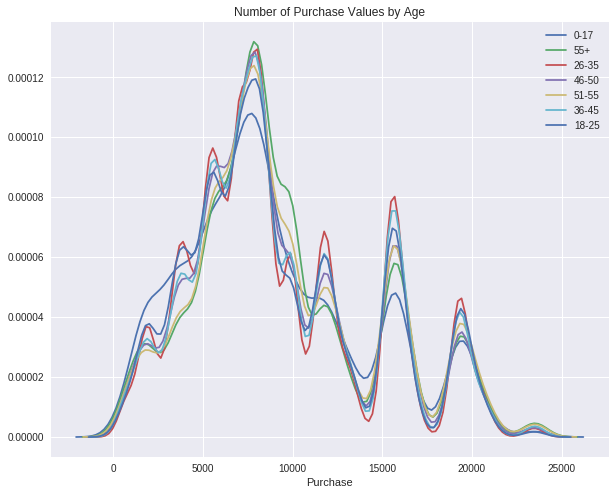

In [0]:
plt.figure(figsize = (10, 8))
for i in df.Age.unique():
    x = df[df.Age == i]
    sns.distplot(x["Purchase"], hist = False, label = i);
plt.title("Number of Purchase Values by Age")

Unsurprisingly, the age group with the lowest amount of purchases is from 0-17. The 0-17 age group also have the smoothest distribution, not exhibiting the same intensity of spikes and dips. The age group with the most purchases is 26-35. 

Text(0.5, 0, 'Product Index')

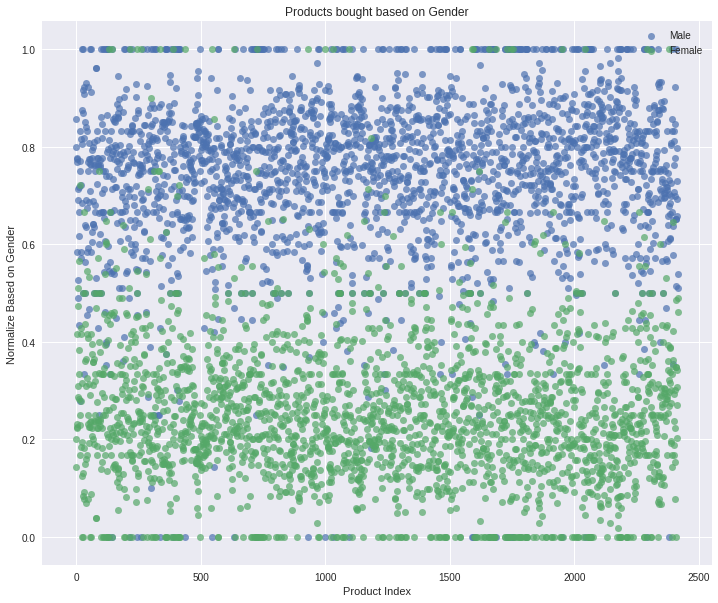

In [0]:
male = df_training['Gender_M']
female = df_training['Gender_F']
x = list(range(2416))
len(male)

plt.figure(figsize=(12,10))
plt.scatter(x, male, cmap = True, label = 'Male', linewidths = 0.001, alpha = 0.7)
plt.scatter(x, female, cmap = True, label = 'Female', linewidths = 0.001, alpha = 0.7)
plt.legend()
plt.title("Products bought based on Gender")
plt.ylabel("Normalize Based on Gender")
plt.xlabel("Product Index")


In [0]:
print("Number of male:", df[df.Gender == "M"].shape[0])
print("Number of female:", df[df.Gender == "F"].shape[0])

Number of male: 405380
Number of female: 132197


For the most part, men purchase more of the product than females. However, the number of men is about 3 times that of females 

In [0]:
importances = list(f_rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_DT.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
                       

Variable: Purchase             Importance: 0.41
Variable: Product_Category_2   Importance: 0.11
Variable: Gender_F             Importance: 0.05
Variable: Gender_M             Importance: 0.05
Variable: Occupation           Importance: 0.05
Variable: Marital_Status       Importance: 0.04
Variable: Age_0-17             Importance: 0.03
Variable: Age_46-50            Importance: 0.03
Variable: Age_51-55            Importance: 0.03
Variable: City_Category_B      Importance: 0.03
Variable: Age_18-25            Importance: 0.02
Variable: Age_26-35            Importance: 0.02
Variable: Age_36-45            Importance: 0.02
Variable: Age_55+              Importance: 0.02
Variable: City_Category_A      Importance: 0.02
Variable: City_Category_C      Importance: 0.02
Variable: Log_Num_Users        Importance: 0.01
Variable: User_ID              Importance: 0.01
Variable: User_ID              Importance: 0.01


From the variable importances of the random forest, it seems that the most important variable when considering splits is the purchase amount and also the product category 2, which makes sense because some product categories are more popular than others and the amount being bought gives an indication of what the product is. Also the product category 2 would probably be similar to the first product category so there would likely be many products that has a specific product category 1 based on what their product category 2 is. 